# Example with the dummy data


The first thing we need to do is import some essential stuff. Theses also have to be installed and are prerequisites.

In [200]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

Now to the fun stuff, we import our module!

In [201]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Random numbers

## Dummy data retrieval

The next thing we want to do is generate a dummy dataset. The dataset is generated by a changepoint each weekend. This are given back as parameter aswell and can be added to the model.

In [221]:
#Create dates for filter/data generation
data_begin = datetime.datetime(2020,3,10)
data_end = datetime.datetime(2020,4,26)

#Get dummy data

lambda_initial = 0.3
mu = 0.12

data, changepoints = cov19.dummy_data.get_dummy_data(data_begin, data_end, lambda_initial, mu,100)
new_cases_obs = data["confirmed"].diff().iloc[1:]

INFO     [covid19_inference.dummy_data] Initial infected 7
INFO     [covid19_inference.dummy_data] Data 7.0
INFO     [covid19_inference.dummy_data] mean 7.000000000090267 var 7.000049000090269
INFO     [covid19_inference.dummy_data] Drawn 9
INFO     [covid19_inference.dummy_data] Data 8.380216391511127
INFO     [covid19_inference.dummy_data] mean 8.380216391490336 var 8.380286619517104
INFO     [covid19_inference.dummy_data] Drawn 9
INFO     [covid19_inference.dummy_data] Data 10.032466023538703
INFO     [covid19_inference.dummy_data] mean 10.032466023490727 var 10.03256667386524
INFO     [covid19_inference.dummy_data] Drawn 8
INFO     [covid19_inference.dummy_data] Data 12.010317870883405
INFO     [covid19_inference.dummy_data] mean 12.010317870903009 var 12.010462118638369
INFO     [covid19_inference.dummy_data] Drawn 11
INFO     [covid19_inference.dummy_data] Data 14.377869253741654
INFO     [covid19_inference.dummy_data] mean 14.377869253623388 var 14.378075976747661
INFO     [covi

INFO     [covid19_inference.dummy_data] Data 3794.2073629834517
INFO     [covid19_inference.dummy_data] mean 3794.207362983526 var 3808.6033724968443
INFO     [covid19_inference.dummy_data] Drawn 3717
INFO     [covid19_inference.dummy_data] Data 3998.238603370908
INFO     [covid19_inference.dummy_data] mean 3998.238603370785 var 4014.224515300269
INFO     [covid19_inference.dummy_data] Drawn 3976
INFO     [covid19_inference.dummy_data] Data 4204.935072037729
INFO     [covid19_inference.dummy_data] mean 4204.935072037674 var 4222.616550997726
INFO     [covid19_inference.dummy_data] Drawn 4107
INFO     [covid19_inference.dummy_data] Data 4413.255986516381
INFO     [covid19_inference.dummy_data] mean 4413.2559865164285 var 4432.732814918952
INFO     [covid19_inference.dummy_data] Drawn 4371
INFO     [covid19_inference.dummy_data] Data 4622.060251753946
INFO     [covid19_inference.dummy_data] mean 4622.060251753935 var 4643.423692724778
INFO     [covid19_inference.dummy_data] Drawn 4673
IN

INFO     [covid19_inference.dummy_data] mean 3148.5423554395984 var 3158.4556744035954
INFO     [covid19_inference.dummy_data] Drawn 3209
INFO     [covid19_inference.dummy_data] Data 3479.2753051735363
INFO     [covid19_inference.dummy_data] mean 3479.275305173557 var 3491.3806618227477
INFO     [covid19_inference.dummy_data] Drawn 3432
INFO     [covid19_inference.dummy_data] Data 3831.0849441829496
INFO     [covid19_inference.dummy_data] mean 3831.0849441829387 var 3845.7621560324837
INFO     [covid19_inference.dummy_data] Drawn 3877
INFO     [covid19_inference.dummy_data] Data 4204.742774149492
INFO     [covid19_inference.dummy_data] mean 4204.742774149395 var 4222.422635946156
INFO     [covid19_inference.dummy_data] Drawn 4244
INFO     [covid19_inference.dummy_data] Data 4600.967377343674
INFO     [covid19_inference.dummy_data] mean 4600.9673773437235 var 4622.136278151104
INFO     [covid19_inference.dummy_data] Drawn 4487
INFO     [covid19_inference.dummy_data] Data 5020.4118027373

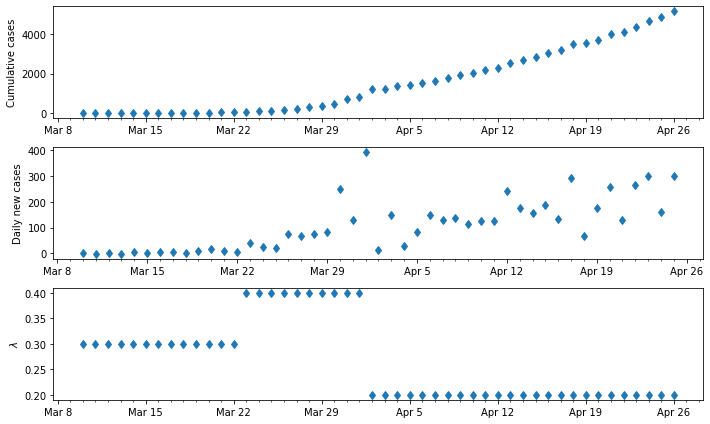

In [222]:
#Plot dummy data
fig, ax = plt.subplots(3,1,figsize=(10,6))
cov19.plot._timeseries(data.index, data["confirmed"] ,ax[0],lw=0)
cov19.plot._timeseries(data.index[:-1], new_cases_obs ,ax[1],lw=0)
cov19.plot._timeseries(data.index, data["lambda_t"] ,ax[2],lw=0)
ax[0].set_ylabel("Cumulative cases")
ax[1].set_ylabel("Daily new cases")
ax[2].set_ylabel(f"$\lambda$")
cov19.plot._format_date_xticks(ax[0])
cov19.plot._format_date_xticks(ax[1])
cov19.plot._format_date_xticks(ax[2])
plt.tight_layout()

In [13]:
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10

#Get priors for changepoints from dummy data
change_points = []
for cp in changepoints:
    change_points.append(dict(pr_mean_date_transient = cp[0],
         pr_sigma_date_transient = 6,
         pr_median_lambda = cp[1],
         pr_sigma_lambda = 2))

Then, create the model:

In [14]:
params_model = dict(new_cases_obs = new_cases_obs,
                    data_begin = data_begin,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # Use this array to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.3)
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5


## MCMC sampling

In [15]:
trace = pm.sample(model=model, tune=500, draws=500, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 319.75:   8%|▊         | 16399/200000 [00:25<04:43, 647.10it/s]
Convergence achieved at 16400
INFO     [pymc3.variational.inference] Convergence achieved at 16400
Interrupted at 16,399 [8%]: Average Loss = 374.89
INFO     [pymc3.variational.inference] Interrupted at 16,399 [8%]: Average Loss = 374.89
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_ra

## Plotting

Plotting tools are rudimentary right now. But one can always write custom plotting function 
by accessing the samples stored in the trace.

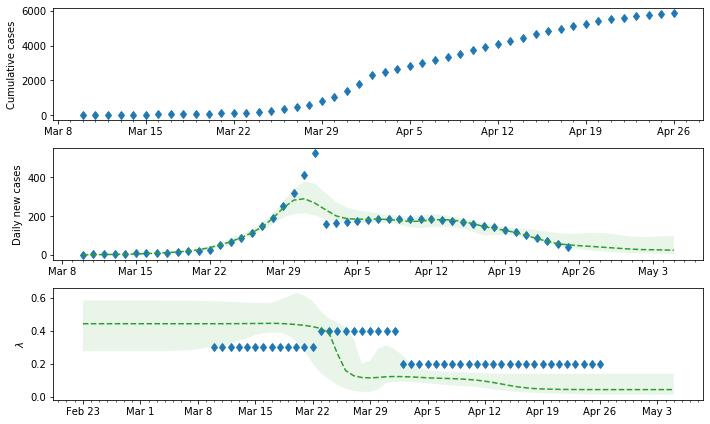

In [16]:

#Plot the model by adding onto the axis from before
y = trace["new_cases"][:,:]
x = pd.date_range(model.data_begin,model.fcast_end-datetime.timedelta(days=0))
cov19.plot._timeseries(x,y,ax[1],what="fcast", draw_ci_95=True)
y = trace["lambda_t"][:,:]
x = pd.date_range(model.sim_begin,model.fcast_end-datetime.timedelta(days=0))
cov19.plot._timeseries(x,y,ax[2],what="fcast", draw_ci_95=True)
fig

We can also compare our changepoints from the dummy data with the changepoints from the trace.

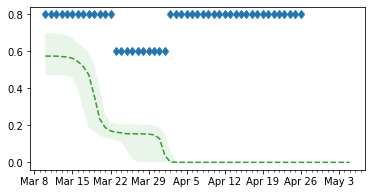

In [65]:
#First the observed changepoints
ax = cov19.plot._timeseries(data.index,
                            data["lambda_t"],
                            what="data",
                            draw_ci_95=False,
                            lw=0)
#Changepoints from trace
x = pd.date_range(model.data_begin,model.sim_end)
y = trace["lambda_t"][:,(model.data_begin-model.sim_begin).days:model.sim_len]

cov19.plot._timeseries(x,y,ax,what="fcast", draw_ci_95=True)
cov19.plot._format_date_xticks(ax)

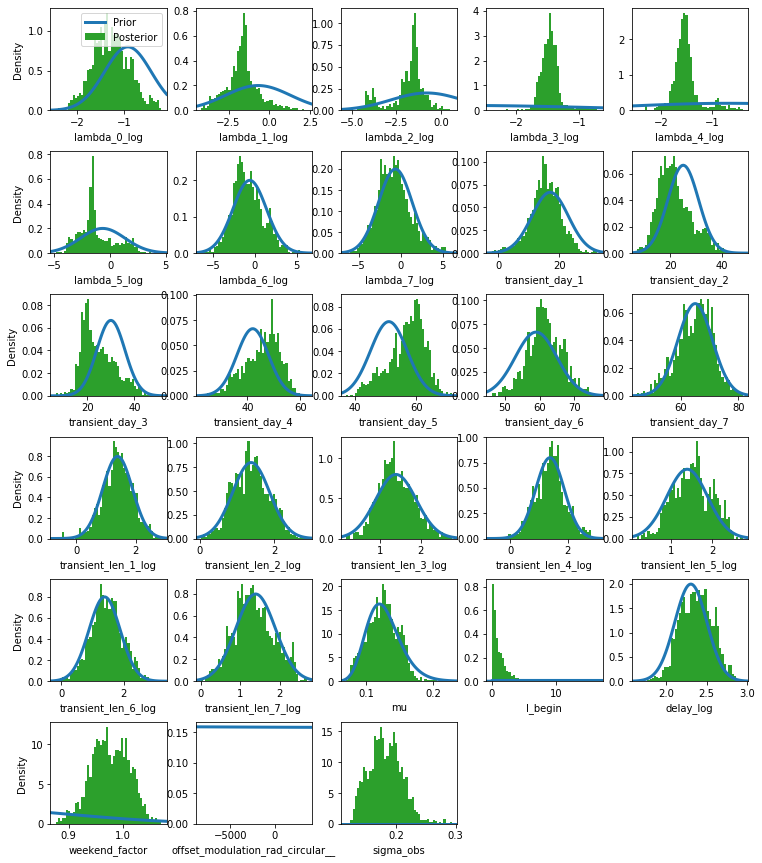

In [198]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)
